# 0. Load Files

In [2]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

import joblib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_parquet("/Users/bennyschellinger/Desktop/DataScience/MLE_DataScientest/04_Projekt/MAY24_BDS_INT_Fire_Brigade/data/df_cleaned_for_classification_models.parquet")
df.head() 

,IncidentGroup_Fire,IncidentGroup_Special Service,AggregatedPropertyCategory_Outdoor,AggregatedPropertyCategory_Residential,AggregatedPropertyCategory_Vehicle,CellEastingNorthing2500_502500-175000,CellEastingNorthing2500_502500-177500,CellEastingNorthing2500_502500-180000,CellEastingNorthing2500_502500-182500,CellEastingNorthing2500_502500-187500,CellEastingNorthing2500_502500-190000,CellEastingNorthing2500_502500-192500,CellEastingNorthing2500_505000-172500,CellEastingNorthing2500_505000-175000,CellEastingNorthing2500_505000-177500,CellEastingNorthing2500_505000-180000,CellEastingNorthing2500_505000-182500,CellEastingNorthing2500_505000-185000,CellEastingNorthing2500_505000-187500,CellEastingNorthing2500_505000-190000,CellEastingNorthing2500_507500-170000,CellEastingNorthing2500_507500-172500,CellEastingNorthing2500_507500-175000,CellEastingNorthing2500_507500-177500,CellEastingNorthing2500_507500-180000,CellEastingNorthing2500_507500-182500,CellEastingNorthing2500_507500-185000,CellEastingNorthing2500_507500-187500,CellEastingNorthing2500_507500-190000,CellEastingNorthing2500_510000-167500,CellEastingNorthing2500_510000-170000,CellEastingNorthing2500_510000-172500,CellEastingNorthing2500_510000-175000,CellEastingNorthing2500_510000-177500,CellEastingNorthing2500_510000-180000,CellEastingNorthing2500_510000-182500,CellEastingNorthing2500_510000-185000,CellEastingNorthing2500_510000-187500,CellEastingNorthing2500_510000-190000,CellEastingNorthing2500_512500-167500,CellEastingNorthing2500_512500-170000,CellEastingNorthing2500_512500-172500,CellEastingNorthing2500_512500-175000,CellEastingNorthing2500_512500-177500,CellEastingNorthing2500_512500-180000,CellEastingNorthing2500_512500-182500,CellEastingNorthing2500_512500-185000,CellEastingNorthing2500_512500-187500,CellEastingNorthing2500_512500-190000,CellEastingNorthing2500_512500-192500,CellEastingNorthing2500_515000-157500,CellEastingNorthing2500_515000-160000,CellEastingNorthing2500_515000-162500,CellEastingNorthing2500_515000-165000,CellEastingNorthing2500_515000-167500,CellEastingNorthing2500_515000-170000,CellEastingNorthing2500_515000-172500,CellEastingNorthing2500_515000-175000,CellEastingNorthing2500_515000-177500,CellEastingNorthing2500_515000-180000,CellEastingNorthing2500_515000-182500,CellEastingNorthing2500_515000-185000,CellEastingNorthing2500_515000-187500,CellEastingNorthing2500_515000-190000,CellEastingNorthing2500_515000-192500,CellEastingNorthing2500_517500-160000,CellEastingNorthing2500_517500-162500,CellEastingNorthing2500_517500-165000,CellEastingNorthing2500_517500-167500,CellEastingNorthing2500_517500-170000,CellEastingNorthing2500_517500-172500,CellEastingNorthing2500_517500-175000,CellEastingNorthing2500_517500-177500,CellEastingNorthing2500_517500-180000,CellEastingNorthing2500_517500-182500,CellEastingNorthing2500_517500-185000,CellEastingNorthing2500_517500-187500,CellEastingNorthing2500_517500-190000,CellEastingNorthing2500_517500-192500,CellEastingNorthing2500_517500-195000,CellEastingNorthing2500_520000-162500,CellEastingNorthing2500_520000-165000,CellEastingNorthing2500_520000-167500,CellEastingNorthing2500_520000-170000,CellEastingNorthing2500_520000-172500,CellEastingNorthing2500_520000-175000,CellEastingNorthing2500_520000-177500,CellEastingNorthing2500_520000-180000,CellEastingNorthing2500_520000-182500,CellEastingNorthing2500_520000-185000,CellEastingNorthing2500_520000-187500,CellEastingNorthing2500_520000-190000,CellEastingNorthing2500_520000-192500,CellEastingNorthing2500_520000-195000,CellEastingNorthing2500_522500-160000,CellEastingNorthing2500_522500-162500,CellEastingNorthing2500_522500-165000,CellEastingNorthing2500_522500-167500,CellEastingNorthing2500_522500-170000,CellEastingNorthing2500_522500-172500,CellEastingNorthing2500_522500-175000,CellEastingNorthing2500_522500-177500,CellEastingNorthing2500_522500-180000,CellEastingNorthing2500_522500-182500,CellEastingNorthing2500_522500-185000,CellEastingNorthing2500_522500-187500,Cel

In [5]:
df.columns

Index(['IncidentGroup_Fire', 'IncidentGroup_Special Service',
       'AggregatedPropertyCategory_Outdoor',
       'AggregatedPropertyCategory_Residential',
       'AggregatedPropertyCategory_Vehicle',
       'CellEastingNorthing2500_502500-175000',
       'CellEastingNorthing2500_502500-177500',
       'CellEastingNorthing2500_502500-180000',
       'CellEastingNorthing2500_502500-182500',
       'CellEastingNorthing2500_502500-187500',
       ...
       'IsBankholiday', 'IsWeekend', 'DistanceStationLog', 'Hour_sin',
       'Hour_cos', 'Weekday_sin', 'Weekday_cos', 'Month_sin', 'Month_cos',
       'ResponseTimeBinary'],
      dtype='object', length=320)

# 1. PCA Transformation & Balancing Data Set

In [9]:
X = df.drop("ResponseTimeBinary", axis = 1)
y = df["ResponseTimeBinary"]


In [14]:
pca = PCA(n_components=0.85)
X_pca = pca.fit_transform(X)

In [15]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size = 0.2, random_state = 666)


In [16]:
rUs = RandomUnderSampler(random_state=666)
X_ru, y_ru = rUs.fit_resample(X_train_pca, y_train_pca)
print('Sample classes undersampled :', dict(pd.Series(y_ru).value_counts()))


Sample classes undersampled : {0: 361454, 1: 361454}


# 2. Voting Classifier

## 2.1 Instantiating XGBoost, RF, & LogReg Models

In [19]:
xgboost = xgb.XGBClassifier(random_state=666)
rf = RandomForestClassifier(random_state=666)
logreg = LogisticRegression(random_state=666)

## 2.2 Instantiating Voting Classifier (Soft)

In [20]:
vclf = VotingClassifier(estimators=[('XGboost', xgboost), ('RF', rf), ('LogReg', logreg)], voting='soft')

## 2.3 Cross Validation via  GridSearchCV

In [21]:
params_xgboost = {
    'XGboost__learning_rate': [0.1],
    'XGboost__max_depth': [5],
    'XGboost__n_estimators': [200],
    'XGboost__subsample': [0.9]
}
params_rf = {
    'RF__criterion': ['gini'],
    'RF__max_depth': [10],
    'RF__n_estimators': [200]
}
params_logreg = {
    'LogReg__C': [5],
    'LogReg__penalty': ['l2'],
    'LogReg__solver': ['lbfgs']
}

# Combine parameters into a single dictionary
params = {**params_xgboost, **params_rf, **params_logreg}

In [24]:
vclf_grid = GridSearchCV(estimator=vclf, param_grid=params, cv=5)
vclf_grid.fit(X_ru, y_ru)

print(vclf_grid.best_params_)

{'LogReg__C': 5, 'LogReg__penalty': 'l2', 'LogReg__solver': 'lbfgs', 'RF__criterion': 'gini', 'RF__max_depth': 10, 'RF__n_estimators': 200, 'XGboost__learning_rate': 0.1, 'XGboost__max_depth': 5, 'XGboost__n_estimators': 200, 'XGboost__subsample': 0.9}


In [25]:
# Save the best model
joblib.dump(vclf_grid, 'vclf_grid.pkl')

# To load the model later
#vclf_grid = joblib.load('vclf_grid.pkl')

['vclf_grid.pkl']

In [30]:
best_voting_clf = vclf_grid.best_estimator_

print("Best Voting Classifier model:")
print(best_voting_clf)

Best Voting Classifier model:
VotingClassifier(estimators=[('XGboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learnin...
                                          

In [31]:
y_pred_train_vclf = best_voting_clf.predict(X_ru)
y_pred_test_vclf = best_voting_clf.predict(X_test_pca)
y_pred_test_prob_vclf = best_voting_clf.predict_proba(X_test_pca)

## 2.4 Model Evaluation (Voting Classifier (Soft))

In [27]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, balanced_accuracy_score

def evaluate_model(y_true, y_pred, y_proba = None):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix:\n', cm)
    
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    
    # Precision, Recall, F1-Score
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    print('Classification Report:\n', classification_report(y_true, y_pred, target_names=['Not Reached (>6 min)', 'Reached (<=6 min)']))
    
    # ROC AUC Score
    if y_proba is not None:
        roc_auc = roc_auc_score(y_true, y_proba[:, 1])
        print(f'ROC AUC Score: {roc_auc:.4f}')
    else:
        roc_auc = None
    
    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    print(f'Balanced Accuracy: {balanced_acc:.4f}')
    
    return accuracy, precision, recall, f1, roc_auc, balanced_acc

In [32]:
print("Voting Classifier (Soft) - Training Data")
evaluate_model(y_ru, y_pred_train_vclf)

Voting Classifier (Soft) - Training Data
Confusion Matrix:
 [[234696 126758]
 [104461 256993]]
Accuracy: 0.6802
Classification Report:
                       precision    recall  f1-score   support

Not Reached (>6 min)       0.69      0.65      0.67    361454
   Reached (<=6 min)       0.67      0.71      0.69    361454

            accuracy                           0.68    722908
           macro avg       0.68      0.68      0.68    722908
        weighted avg       0.68      0.68      0.68    722908

Balanced Accuracy: 0.6802


(0.6801543211584323,
 0.6808424777052964,
 0.6801543211584323,
 0.6798497557026433,
 None,
 0.6801543211584323)

In [33]:
print("\nVoting Classifier (Soft)  - Test Data")
vclf_test_acc, vclf_test_prec, vclf_test_recall, vclf_test_f1, vclf_test_roc, vclf_test_balacc = evaluate_model(y_test_pca, y_pred_test_vclf, y_pred_test_prob_vclf)


Voting Classifier (Soft)  - Test Data
Confusion Matrix:
 [[ 58153  32090]
 [ 63725 153573]]
Accuracy: 0.6884
Classification Report:
                       precision    recall  f1-score   support

Not Reached (>6 min)       0.48      0.64      0.55     90243
   Reached (<=6 min)       0.83      0.71      0.76    217298

            accuracy                           0.69    307541
           macro avg       0.65      0.68      0.66    307541
        weighted avg       0.72      0.69      0.70    307541

ROC AUC Score: 0.7364
Balanced Accuracy: 0.6756


## 2.5 Instantiating Voting Classifier (Hard)

In [41]:
vclf_hard = VotingClassifier(estimators=[('XGboost', xgboost), ('RF', rf), ('LogReg', logreg)], voting='hard')

## 2.6 Cross Validation via  GridSearchCV

In [42]:
vclf_hard_grid = GridSearchCV(estimator=vclf_hard, param_grid=params, cv=5)
vclf_hard_grid.fit(X_ru, y_ru)

GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('XGboost',
                                                     XGBClassifier(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   device=None,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                                   feature_types=None,
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interact...
                                                     RandomForestClassifier(random_state=666)),
                                                    ('LogReg',
                                                     LogisticRegression(random_state=666))]),
             param_grid={'LogReg__C': [5], 'LogReg__penalty': ['l2'],
                         'LogReg__solver': ['lbfgs'], 'RF__criterion': ['gini'],
                         'RF__max_depth': [10], 'RF__n_estimators': [200],
                         'XGboost__learning_rate': [0.1],
                         'XGboost__max_depth': [5],
                         'XGboost__n_estimators': [200],
                         'XGboost__subsample': [0.9]})

In [3]:
# Save the best model
joblib.dump(vclf_hard_grid.best_estimators, 'vclf_hard_grid.pkl')

# To load the model later
#vclf_hard_grid = joblib.load('vclf_hard_grid.pkl')

NameError: name 'vclf_hard_grid' is not defined

In [44]:
best_voting_clf_hard = vclf_hard_grid.best_estimator_

print("Best Voting Classifier model:")
print(best_voting_clf_hard)

Best Voting Classifier model:
VotingClassifier(estimators=[('XGboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learnin...
                                          

In [46]:
y_pred_train_vclf_hard = best_voting_clf_hard.predict(X_ru)
y_pred_test_vclf_hard = best_voting_clf_hard.predict(X_test_pca)


## 2.7 Model Evaluation (Voting Classifier (Hard))

In [47]:
print("Voting Classifier (Hard) - Training Data")
evaluate_model(y_ru, y_pred_train_vclf_hard)

Voting Classifier (Hard) - Training Data
Confusion Matrix:
 [[231781 129673]
 [101299 260155]]
Accuracy: 0.6805
Classification Report:
                       precision    recall  f1-score   support

Not Reached (>6 min)       0.70      0.64      0.67    361454
   Reached (<=6 min)       0.67      0.72      0.69    361454

            accuracy                           0.68    722908
           macro avg       0.68      0.68      0.68    722908
        weighted avg       0.68      0.68      0.68    722908

Balanced Accuracy: 0.6805


(0.6804959967243411,
 0.6816151436783779,
 0.6804959967243411,
 0.6800030262164066,
 None,
 0.6804959967243411)

In [49]:
print("\nVoting Classifier (Hard)  - Test Data")
vclf_hard_test_acc, vclf_hard_test_prec, vclf_hard_test_recall, vclf_hard_test_f1, vclf_hard_test_roc, vclf_hard_test_balacc = evaluate_model(y_test_pca, y_pred_test_vclf_hard, y_pred_test_prob_vclf_hard)


Voting Classifier (Hard)  - Test Data
Confusion Matrix:
 [[ 57374  32869]
 [ 61874 155424]]
Accuracy: 0.6919
Classification Report:
                       precision    recall  f1-score   support

Not Reached (>6 min)       0.48      0.64      0.55     90243
   Reached (<=6 min)       0.83      0.72      0.77    217298

            accuracy                           0.69    307541
           macro avg       0.65      0.68      0.66    307541
        weighted avg       0.72      0.69      0.70    307541

Balanced Accuracy: 0.6755


# 3. Stacking

## 3.1 Instantiating Base Estimators (XGBoost, RF, & LogReg Models)

In [51]:
estimators = [
    ('rf', RandomForestClassifier(random_state=666)),
    ('logreg', LogisticRegression(random_state=666)),
    ('xgboost', xgb.XGBClassifier(random_state=666))
]

meta_classifier = xgb.XGBClassifier(random_state=666)

## 3.2 Instantiating Stacking Classifier

In [52]:
sclf = StackingClassifier(estimators=estimators, final_estimator=meta_classifier, passthrough=False)

## 3.3 Cross Validation via  GridSearchCV

In [53]:
param_grid_sclf = {
    'rf__criterion': ['gini'],
    'rf__max_depth': [10],
    'rf__n_estimators': [200],
    'logreg__C': [5],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['lbfgs'],
    'xgboost__learning_rate': [0.1],
    'xgboost__max_depth': [5],
    'xgboost__n_estimators': [200],
    'xgboost__subsample': [0.9],
    'final_estimator__learning_rate': [0.1, 0.01],
    'final_estimator__max_depth': [10],
    'final_estimator__n_estimators': [200],
    'final_estimator__subsample': [0.9]
}

In [54]:
sclf_grid = GridSearchCV(estimator=sclf, param_grid=param_grid_sclf, cv=5)

In [55]:
sclf_grid.fit(X_ru, y_ru)

GridSearchCV(cv=5,
             estimator=StackingClassifier(estimators=[('rf',
                                                       RandomForestClassifier(random_state=666)),
                                                      ('logreg',
                                                       LogisticRegression(random_state=666)),
                                                      ('xgboost',
                                                       XGBClassifier(base_score=None,
                                                                     booster=None,
                                                                     callbacks=None,
                                                                     colsample_bylevel=None,
                                                                     colsample_bynode=None,
                                                                     colsample_bytree=None,
                                                                     device=None,
                                                                     early_stopping_rounds=None,
                                                                     enable_categorical=F...
                         'final_estimator__max_depth': [10],
                         'final_estimator__n_estimators': [200],
                         'final_estimator__subsample': [0.9], 'logreg__C': [5],
                         'logreg__penalty': ['l2'], 'logreg__solver': ['lbfgs'],
                         'rf__criterion': ['gini'], 'rf__max_depth': [10],
                         'rf__n_estimators': [200],
                         'xgboost__learning_rate': [0.1],
                         'xgboost__max_depth': [5],
                         'xgboost__n_estimators': [200],
                         'xgboost__subsample': [0.9]})

In [58]:
# Save the best model
joblib.dump(sclf_grid, 'sclf_grid.pkl')

# To load the model later
#sclf_grid = joblib.load('sclf_grid.pkl')

['sclf_grid.pkl']

In [59]:
print(sclf_grid.best_params_)

{'final_estimator__learning_rate': 0.01, 'final_estimator__max_depth': 10, 'final_estimator__n_estimators': 200, 'final_estimator__subsample': 0.9, 'logreg__C': 5, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'rf__criterion': 'gini', 'rf__max_depth': 10, 'rf__n_estimators': 200, 'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 5, 'xgboost__n_estimators': 200, 'xgboost__subsample': 0.9}


In [60]:
# Get the best StackingClassifier model
best_stacking_clf = sclf_grid.best_estimator_

print("Best Stacking Classifier model:")
print(best_stacking_clf)

Best Stacking Classifier model:
StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=10,
                                                       n_estimators=200,
                                                       random_state=666)),
                               ('logreg',
                                LogisticRegression(C=5, random_state=666)),
                               ('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categor...
        

In [61]:
y_pred_train_sclf = best_stacking_clf.predict(X_ru)
y_pred_test_sclf = best_stacking_clf.predict(X_test_pca)
y_pred_test_prob_sclf = best_stacking_clf.predict_proba(X_test_pca)

## 3.4 Model Evaluation (Stacking Classifier)

In [71]:
print("Stacking Classifier - Training Data")
evaluate_model(y_ru, y_pred_train_sclf)

Stacking Classifier - Training Data
Confusion Matrix:
 [[229635 131819]
 [ 97786 263668]]
Accuracy: 0.6824
Classification Report:
                       precision    recall  f1-score   support

Not Reached (>6 min)       0.70      0.64      0.67    361454
   Reached (<=6 min)       0.67      0.73      0.70    361454

            accuracy                           0.68    722908
           macro avg       0.68      0.68      0.68    722908
        weighted avg       0.68      0.68      0.68    722908

Balanced Accuracy: 0.6824


(0.6823869704028729,
 0.68401835190583,
 0.6823869704028729,
 0.6816814715300483,
 None,
 0.6823869704028729)

In [70]:
print("\nStacking Classifier - Test Data")
sclf_hard_test_acc, sclf_hard_test_prec, sclf_hard_test_recall, sclf_hard_test_f1, sclf_hard_test_roc, sclf_hard_test_balacc = evaluate_model(y_test_pca, y_pred_test_sclf, y_pred_test_prob_sclf)


Stacking Classifier - Test Data
Confusion Matrix:
 [[ 56715  33528]
 [ 59716 157582]]
Accuracy: 0.6968
Classification Report:
                       precision    recall  f1-score   support

Not Reached (>6 min)       0.49      0.63      0.55     90243
   Reached (<=6 min)       0.82      0.73      0.77    217298

            accuracy                           0.70    307541
           macro avg       0.66      0.68      0.66    307541
        weighted avg       0.73      0.70      0.71    307541

ROC AUC Score: 0.7403
Balanced Accuracy: 0.6768


#### Evaluation Decision Tree (Training Data, Undersampled)

In [114]:
print("Decision Tree - Training Data (Undersampled)")
evaluate_model(y_undsam, y_train_pred_dt_undsam)

Decision Tree - Training Data (Undersampled)
Confusion Matrix:
 [[361411     43]
 [  1637 359817]]
Accuracy: 0.9977
Classification Report:
                       precision    recall  f1-score   support

Not Reached (>6 min)       1.00      1.00      1.00    361454
   Reached (<=6 min)       1.00      1.00      1.00    361454

            accuracy                           1.00    722908
           macro avg       1.00      1.00      1.00    722908
        weighted avg       1.00      1.00      1.00    722908

Balanced Accuracy: 0.9977


(0.9976760528310656,
 0.9976857317255141,
 0.9976760528310656,
 0.9976760415320935,
 None,
 0.9976760528310656)

#### Evaluation Decision Tree (Test Data, Undersampled)

In [115]:
print("Decision Tree - Test Data (Undersampled)")
dt_test_acc_ru, dt_test_prec_ru, dt_test_recall_ru, dt_test_f1_ru, dt_test_roc_ru, dt_test_balacc_ru = evaluate_model(y_test, y_test_pred_dt_undsam, y_test_pred_prob_dt_undsam)

Decision Tree - Test Data (Undersampled)
Confusion Matrix:
 [[ 54750  35493]
 [ 84002 133296]]
Accuracy: 0.6115
Classification Report:
                       precision    recall  f1-score   support

Not Reached (>6 min)       0.39      0.61      0.48     90243
   Reached (<=6 min)       0.79      0.61      0.69    217298

            accuracy                           0.61    307541
           macro avg       0.59      0.61      0.58    307541
        weighted avg       0.67      0.61      0.63    307541

ROC AUC Score: 0.6104
Balanced Accuracy: 0.6101


#### Evaluation Random Forest (Training Data, Undersampled)

In [116]:
print("\nRandom Forest - Training Data (Undersampled)")
evaluate_model(y_undsam, y_train_pred_rf_undsam)


Random Forest - Training Data (Undersampled)
Confusion Matrix:
 [[360493    961]
 [   725 360729]]
Accuracy: 0.9977
Classification Report:
                       precision    recall  f1-score   support

Not Reached (>6 min)       1.00      1.00      1.00    361454
   Reached (<=6 min)       1.00      1.00      1.00    361454

            accuracy                           1.00    722908
           macro avg       1.00      1.00      1.00    722908
        weighted avg       1.00      1.00      1.00    722908

Balanced Accuracy: 0.9977


(0.997667753019748,
 0.9976679651768732,
 0.997667753019748,
 0.9976677527711872,
 None,
 0.997667753019748)

#### Evaluation Random Forest (Test Data, Undersampled)

In [117]:
print("\nRandom Forest - Test Data (Undersampled)")
rf_test_acc_ru, rf_test_prec_ru, rf_test_recall_ru, rf_test_f1_ru, rf_test_roc_ru, rf_test_balacc_ru = evaluate_model(y_test, y_test_pred_rf_undsam, y_test_pred_prob_rf_undsam)


Random Forest - Test Data (Undersampled)
Confusion Matrix:
 [[ 58666  31577]
 [ 68834 148464]]
Accuracy: 0.6735
Classification Report:
                       precision    recall  f1-score   support

Not Reached (>6 min)       0.46      0.65      0.54     90243
   Reached (<=6 min)       0.82      0.68      0.75    217298

            accuracy                           0.67    307541
           macro avg       0.64      0.67      0.64    307541
        weighted avg       0.72      0.67      0.69    307541

ROC AUC Score: 0.7277
Balanced Accuracy: 0.6667


In [8]:
pca = PCA()
X_pca = pca.fit_transform(X)


[6.54343175e-01 5.32203300e-01 5.14806503e-01 4.99943112e-01
 4.94973216e-01 4.68662112e-01 4.10316762e-01 3.39185563e-01
 2.02460411e-01 1.32471758e-01 8.02194373e-02 5.61907431e-02
 3.66088534e-02 3.09488398e-02 2.35764774e-02 1.98372054e-02
 1.94383179e-02 1.76447192e-02 1.69618682e-02 1.64500815e-02
 1.58425773e-02 1.46603844e-02 1.42345540e-02 1.35775544e-02
 1.32694346e-02 1.29845808e-02 1.26124480e-02 1.24052394e-02
 1.22416831e-02 1.20193491e-02 1.16364237e-02 1.11694136e-02
 1.09158207e-02 1.05987744e-02 9.98372087e-03 8.61115142e-03
 8.56080275e-03 8.48274970e-03 8.36406406e-03 8.28231912e-03
 8.16525216e-03 8.03769044e-03 7.90005631e-03 7.73628252e-03
 7.59606412e-03 7.45665415e-03 7.33549350e-03 7.20886705e-03
 7.01339151e-03 6.90470752e-03 6.76307645e-03 6.71921761e-03
 6.58420778e-03 6.45850090e-03 6.34080042e-03 6.26672350e-03
 6.18509683e-03 6.09276247e-03 6.01998382e-03 5.92318910e-03
 5.83856578e-03 5.75297354e-03 5.73304030e-03 5.64229880e-03
 5.59008100e-03 5.499493

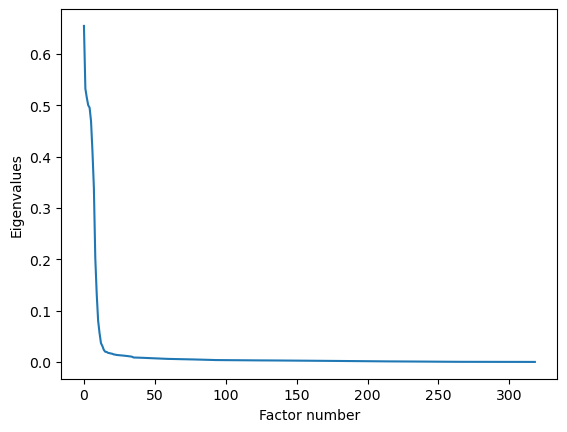

In [9]:
print(pca.explained_variance_)

plt.plot(range(0,len(pca.explained_variance_)), pca.explained_variance_)
plt.xlabel('Factor number')
plt.ylabel('Eigenvalues');


[1.20620767e-01 9.81056615e-02 9.48987587e-02 9.21588605e-02
 9.12427164e-02 8.63925618e-02 7.56372562e-02 6.25250239e-02
 3.73212879e-02 2.44196709e-02 1.47875463e-02 1.03581282e-02
 6.74842823e-03 5.70506872e-03 4.34605707e-03 3.65676454e-03
 3.58323414e-03 3.25260450e-03 3.12672864e-03 3.03238655e-03
 2.92040001e-03 2.70247611e-03 2.62397909e-03 2.50286864e-03
 2.44607025e-03 2.39356068e-03 2.32496219e-03 2.28676563e-03
 2.25661588e-03 2.21563113e-03 2.14504316e-03 2.05895513e-03
 2.01220813e-03 1.95376424e-03 1.84038607e-03 1.58736841e-03
 1.57808720e-03 1.56369900e-03 1.54182065e-03 1.52675189e-03
 1.50517192e-03 1.48165736e-03 1.45628606e-03 1.42609622e-03
 1.40024854e-03 1.37454989e-03 1.35221529e-03 1.32887314e-03
 1.29283943e-03 1.27280477e-03 1.24669668e-03 1.23861180e-03
 1.21372427e-03 1.19055162e-03 1.16885487e-03 1.15519963e-03
 1.14015267e-03 1.12313188e-03 1.10971596e-03 1.09187294e-03
 1.07627359e-03 1.06049563e-03 1.05682116e-03 1.04009399e-03
 1.03046823e-03 1.013769

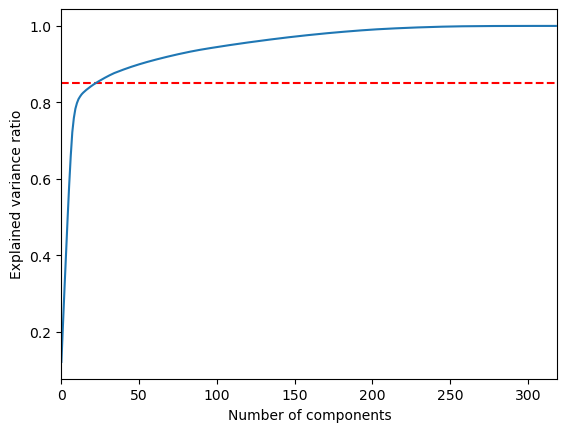

In [11]:
print(pca.explained_variance_ratio_)

plt.figure()
plt.xlim(0,len(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.axhline(y = 0.85, color = 'r', linestyle = '--')
plt.plot(pca.explained_variance_ratio_.cumsum());


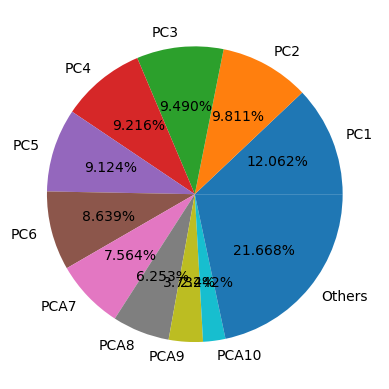

In [12]:
# Pie chart of the distribution of the explained variance ratio by each axis.
L1 = list(pca.explained_variance_ratio_[0:10]) # first 6 main principal components
L1.append(sum(pca.explained_variance_ratio_[10:X_pca.shape[1]])) # "Others"


plt.pie(L1, labels=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PCA7', 'PCA8', 'PCA9', 'PCA10', 'Others'], autopct='%1.3f%%');


In [13]:
print("Explained Variance for 10 Components:",pca.explained_variance_ratio_[0:10].sum())
print("Explained Variance for 20 Components:",pca.explained_variance_ratio_[0:20].sum())
print("Explained Variance for 50 Components:",pca.explained_variance_ratio_[0:30].sum())

Explained Variance for 10 Components: 0.7833225643185457
Explained Variance for 20 Components: 0.8419195112468112
Explained Variance for 50 Components: 0.8665928408487957


#### PCA with 85% Explained Variance

In [14]:
pca = PCA(n_components=0.85)
X_pca = pca.fit_transform(X)

In [20]:
print("Number of components with 85% explained variance:", len(pca.explained_variance_ratio_))
print("Number of PCA transformed features:", X_pca.shape[1])

Number of components with 85% explained variance: 23
Number of PCA transformed features: 23


In [21]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size = 0.2, random_state = 666)

In [22]:
rUs = RandomUnderSampler(random_state=666)
X_ru, y_ru = rUs.fit_resample(X_train_pca, y_train_pca)
print('Sample classes undersampled :', dict(pd.Series(y_ru).value_counts()))


Sample classes undersampled : {0: 361454, 1: 361454}


In [99]:
decision_tree_pca_ru = DecisionTreeClassifier(random_state=666)
decision_tree_pca_ru.fit(X_ru, y_ru)

DecisionTreeClassifier(random_state=666)

In [155]:
# Save the best model
joblib.dump(decision_tree_pca_ru, 'best_dt_pca_ru.pkl')

# To load the model later
#decision_tree_pca_ru = joblib.load('best_dt_pca_ru.pkl')

['best_dt_pca_ru.pkl']

In [100]:
y_train_pred_dt_pca_ru = decision_tree_pca_ru.predict(X_ru)
y_test_pred_dt_pca_ru = decision_tree_pca_ru.predict(X_test_pca)
y_test_pred_prob_dt_pca_ru = decision_tree_pca_ru.predict_proba(X_test_pca)

In [101]:
random_forest_pca_ru = RandomForestClassifier(random_state=666)
random_forest_pca_ru.fit(X_ru, y_ru)

RandomForestClassifier(random_state=666)

In [159]:
# Save the best model
joblib.dump(random_forest_pca_ru, 'best_rf_pca_ru.pkl')

# To load the model later
#random_forest_pca_ru = joblib.load('best_rf_pca_ru.pkl')

['best_rf_pca_ru.pkl']

In [102]:
y_train_pred_rf_pca_ru = random_forest_pca_ru.predict(X_ru)
y_test_pred_rf_pca_ru = random_forest_pca_ru.predict(X_test_pca)
y_test_pred_prob_rf_pca_ru = random_forest_pca_ru.predict_proba(X_test_pca)

#### Evaluation Decision Tree (Training Data, PCA + Undersampled)

In [103]:
print("Decision Tree - Training Data (PCA + Undersampled)")
evaluate_model(y_ru, y_train_pred_dt_pca_ru)

Decision Tree - Training Data (PCA + Undersampled)
Confusion Matrix:
 [[361411     43]
 [  1637 359817]]
Accuracy: 0.9977
Classification Report:
                       precision    recall  f1-score   support

Not Reached (>6 min)       1.00      1.00      1.00    361454
   Reached (<=6 min)       1.00      1.00      1.00    361454

            accuracy                           1.00    722908
           macro avg       1.00      1.00      1.00    722908
        weighted avg       1.00      1.00      1.00    722908

Balanced Accuracy: 0.9977


(0.9976760528310656,
 0.9976857317255141,
 0.9976760528310656,
 0.9976760415320935,
 None,
 0.9976760528310656)

#### Evaluation Decision Tree (Test Data, PCA + Undersampled)

In [104]:
print("\nDecision Tree - Test Data (PCA + Undersampled)")
dt_test_acc_pca_ru, dt_test_prec_pca_ru, dt_test_recall_pca_ru, dt_test_f1_pca_ru, dt_test_roc_pca_ru, dt_test_balacc_pca_ru = evaluate_model(y_test_pca, y_test_pred_dt_pca_ru, y_test_pred_prob_dt_pca_ru)


Decision Tree - Test Data (PCA + Undersampled)
Confusion Matrix:
 [[ 53205  37038]
 [ 90053 127245]]
Accuracy: 0.5868
Classification Report:
                       precision    recall  f1-score   support

Not Reached (>6 min)       0.37      0.59      0.46     90243
   Reached (<=6 min)       0.77      0.59      0.67    217298

            accuracy                           0.59    307541
           macro avg       0.57      0.59      0.56    307541
        weighted avg       0.66      0.59      0.60    307541

ROC AUC Score: 0.5879
Balanced Accuracy: 0.5876


#### Evaluation Random Forest (Training Data, PCA + Undersampled)

In [105]:
print("\nRandom Forest - Training Data (PCA + Undersampled)")
evaluate_model(y_ru, y_train_pred_rf_pca_ru)


Random Forest - Training Data (PCA + Undersampled)
Confusion Matrix:
 [[360514    940]
 [   744 360710]]
Accuracy: 0.9977
Classification Report:
                       precision    recall  f1-score   support

Not Reached (>6 min)       1.00      1.00      1.00    361454
   Reached (<=6 min)       1.00      1.00      1.00    361454

            accuracy                           1.00    722908
           macro avg       1.00      1.00      1.00    722908
        weighted avg       1.00      1.00      1.00    722908

Balanced Accuracy: 0.9977


(0.9976705196235206,
 0.997670665958488,
 0.9976705196235206,
 0.9976705194522806,
 None,
 0.9976705196235206)

In [106]:
print("\nRandom Forest - Test Data (PCA + Undersampled)")
rf_test_acc_pca_ru, rf_test_prec_pca_ru, rf_test_recall_pca_ru, rf_test_f1_pca_ru, rf_test_roc_pca_ru, rf_test_balacc_pca_ru = evaluate_model(y_test_pca, y_test_pred_rf_pca_ru, y_test_pred_prob_rf_pca_ru)


Random Forest - Test Data (PCA + Undersampled)
Confusion Matrix:
 [[ 57670  32573]
 [ 70070 147228]]
Accuracy: 0.6662
Classification Report:
                       precision    recall  f1-score   support

Not Reached (>6 min)       0.45      0.64      0.53     90243
   Reached (<=6 min)       0.82      0.68      0.74    217298

            accuracy                           0.67    307541
           macro avg       0.64      0.66      0.64    307541
        weighted avg       0.71      0.67      0.68    307541

ROC AUC Score: 0.7162
Balanced Accuracy: 0.6583


In [23]:
from sklearn.model_selection import GridSearchCV

In [43]:
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10],
    'max_features': ['sqrt', 'log2'],
    'random_state': [666] 
}

grid_search_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=param_grid_dt,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

In [44]:
grid_search_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [10],
                         'max_features': ['sqrt', 'log2'],
                         'random_state': [666]},
             scoring='accuracy')

In [151]:
# Save the best model
joblib.dump(grid_search_dt.best_estimator_, 'best_dt_hyp.pkl')

# To load the model later
#grid_search_dt = joblib.load('best_dt_hyp.pkl')

['best_dt_hyp.pkl']

In [45]:
y_train_pred_dt_hyp = grid_search_dt.predict(X_train)
y_test_pred_dt_hyp = grid_search_dt.predict(X_test)
y_test_pred_prob_dt_hyp = grid_search_dt.predict_proba(X_test)

In [53]:
param_grid_rf = {
    'n_estimators': [100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10],
    'max_features': ['sqrt'],
    'random_state': [666]
}

grid_search_rf_hyp = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

In [54]:
grid_search_rf_hyp.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [10],
                         'max_features': ['sqrt'], 'n_estimators': [100],
                         'random_state': [666]},
             scoring='accuracy')

In [152]:
# Save the best model
joblib.dump(grid_search_rf_hyp.best_estimator_, 'best_rf_hyp.pkl')

# To load the model later
#grid_search_rf_hyp = joblib.load('best_rf_hyp.pkl')

['best_rf_hyp.pkl']

In [55]:
y_train_pred_rf_hyp = grid_search_rf_hyp.predict(X_train)
y_test_pred_rf_hyp = grid_search_rf_hyp.predict(X_test)
y_test_pred_prob_rf_hyp = grid_search_rf_hyp.predict_proba(X_test)

In [46]:
print("Decision Tree - Training Data (Hyperparameter)")
evaluate_model(y_train, y_train_pred_dt_hyp)

Decision Tree - Training Data
Confusion Matrix:
 [[ 55539 305915]
 [ 38074 830635]]
Accuracy: 0.7204
Classification Report:
                       precision    recall  f1-score   support

Not Reached (>6 min)       0.59      0.15      0.24    361454
   Reached (<=6 min)       0.73      0.96      0.83    868709

            accuracy                           0.72   1230163
           macro avg       0.66      0.55      0.54   1230163
        weighted avg       0.69      0.72      0.66   1230163

Balanced Accuracy: 0.5549


(0.7203712028405992,
 0.6620609633071782,
 0.5549130757156897,
 0.5362740514096647,
 None,
 0.5549130757156897)

In [47]:
print("\nDecision Tree - Test Data (Hyperparameter)")
dt_test_acc_hyp, dt_test_prec_hyp, dt_test_recall_hyp,dt_test_f1_hyp, dt_test_roc_hyp, dt_test_balacc_hyp = evaluate_model(y_test, y_test_pred_dt_hyp, y_test_pred_prob_dt_hyp)


Decision Tree - Test Data
Confusion Matrix:
 [[ 13735  76508]
 [  9832 207466]]
Accuracy: 0.7193
Classification Report:
                       precision    recall  f1-score   support

Not Reached (>6 min)       0.58      0.15      0.24     90243
   Reached (<=6 min)       0.73      0.95      0.83    217298

            accuracy                           0.72    307541
           macro avg       0.66      0.55      0.53    307541
        weighted avg       0.69      0.72      0.66    307541

ROC AUC Score: 0.6427
Balanced Accuracy: 0.5535


# 7. Comparison of Different Models

## 7.1 Evaluation Metrics Comparison

In [66]:
'''
Random Forest - Test Data (Undersampled + Hyperparameter + PCA)
Confusion Matrix:
 [[ 55218  35025]
 [ 57654 159644]]
Classification Report:
                       precision    recall  f1-score   support

Not Reached (>6 min)       0.49      0.61      0.54     90243
   Reached (<=6 min)       0.82      0.73      0.78    217298

            accuracy                           0.70    307541
           macro avg       0.65      0.67      0.66    307541
        weighted avg       0.72      0.70      0.71    307541

ROC AUC Score: 0.7352
Balanced Accuracy: 0.6733
'''

'\nRandom Forest - Test Data (Undersampled + Hyperparameter + PCA)\nConfusion Matrix:\n [[ 55218  35025]\n [ 57654 159644]]\nClassification Report:\n                       precision    recall  f1-score   support\n\nNot Reached (>6 min)       0.49      0.61      0.54     90243\n   Reached (<=6 min)       0.82      0.73      0.78    217298\n\n            accuracy                           0.70    307541\n           macro avg       0.65      0.67      0.66    307541\n        weighted avg       0.72      0.70      0.71    307541\n\nROC AUC Score: 0.7352\nBalanced Accuracy: 0.6733\n'

In [67]:
'''
XGBoost with best hyperparameter

Test Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.62      0.55     90243
           1       0.82      0.73      0.77    217298

    accuracy                           0.70    307541
   macro avg       0.66      0.68      0.66    307541
weighted avg       0.73      0.70      0.71    307541

Test ROC-AUC Score: 0.7410707514722088

Accuracy: 0.6986
'''

'\nXGBoost with best hyperparameter\n\nTest Classification Report:\n              precision    recall  f1-score   support\n\n           0       0.49      0.62      0.55     90243\n           1       0.82      0.73      0.77    217298\n\n    accuracy                           0.70    307541\n   macro avg       0.66      0.68      0.66    307541\nweighted avg       0.73      0.70      0.71    307541\n\nTest ROC-AUC Score: 0.7410707514722088\n\nAccuracy: 0.6986\n'

In [69]:
'''
Voting Classifier (Soft)  - Test Data
Confusion Matrix:
 [[ 58153  32090]
 [ 63725 153573]]
Accuracy: 0.6884
Classification Report:
                       precision    recall  f1-score   support

Not Reached (>6 min)       0.48      0.64      0.55     90243
   Reached (<=6 min)       0.83      0.71      0.76    217298

            accuracy                           0.69    307541
           macro avg       0.65      0.68      0.66    307541
        weighted avg       0.72      0.69      0.70    307541

ROC AUC Score: 0.7364
Balanced Accuracy: 0.6756
'''

'\nVoting Classifier (Soft)  - Test Data\nConfusion Matrix:\n [[ 58153  32090]\n [ 63725 153573]]\nAccuracy: 0.6884\nClassification Report:\n                       precision    recall  f1-score   support\n\nNot Reached (>6 min)       0.48      0.64      0.55     90243\n   Reached (<=6 min)       0.83      0.71      0.76    217298\n\n            accuracy                           0.69    307541\n           macro avg       0.65      0.68      0.66    307541\n        weighted avg       0.72      0.69      0.70    307541\n\nROC AUC Score: 0.7364\nBalanced Accuracy: 0.6756\n'

In [73]:
'''
Voting Classifier (Hard)  - Test Data
Confusion Matrix:
 [[ 57374  32869]
 [ 61874 155424]]
Accuracy: 0.6919
Classification Report:
                       precision    recall  f1-score   support

Not Reached (>6 min)       0.48      0.64      0.55     90243
   Reached (<=6 min)       0.83      0.72      0.77    217298

            accuracy                           0.69    307541
           macro avg       0.65      0.68      0.66    307541
        weighted avg       0.72      0.69      0.70    307541

Balanced Accuracy: 0.6755
'''

'\nVoting Classifier (Soft)  - Test Data\nConfusion Matrix:\n [[ 58153  32090]\n [ 63725 153573]]\nAccuracy: 0.6884\nClassification Report:\n                       precision    recall  f1-score   support\n\nNot Reached (>6 min)       0.48      0.64      0.55     90243\n   Reached (<=6 min)       0.83      0.71      0.76    217298\n\n            accuracy                           0.69    307541\n           macro avg       0.65      0.68      0.66    307541\n        weighted avg       0.72      0.69      0.70    307541\n\nROC AUC Score: 0.7364\nBalanced Accuracy: 0.6756\n'

In [72]:
'''
Stacking Classifier - Test Data
Confusion Matrix:
 [[ 56715  33528]
 [ 59716 157582]]
Accuracy: 0.6968
Classification Report:
                       precision    recall  f1-score   support

Not Reached (>6 min)       0.49      0.63      0.55     90243
   Reached (<=6 min)       0.82      0.73      0.77    217298

            accuracy                           0.70    307541
           macro avg       0.66      0.68      0.66    307541
        weighted avg       0.73      0.70      0.71    307541

ROC AUC Score: 0.7403
Balanced Accuracy: 0.6768
'''

'\nStacking Classifier - Test Data\nConfusion Matrix:\n [[ 56715  33528]\n [ 59716 157582]]\nAccuracy: 0.6968\nClassification Report:\n                       precision    recall  f1-score   support\n\nNot Reached (>6 min)       0.49      0.63      0.55     90243\n   Reached (<=6 min)       0.82      0.73      0.77    217298\n\n            accuracy                           0.70    307541\n           macro avg       0.66      0.68      0.66    307541\n        weighted avg       0.73      0.70      0.71    307541\n\nROC AUC Score: 0.7403\nBalanced Accuracy: 0.6768\n'

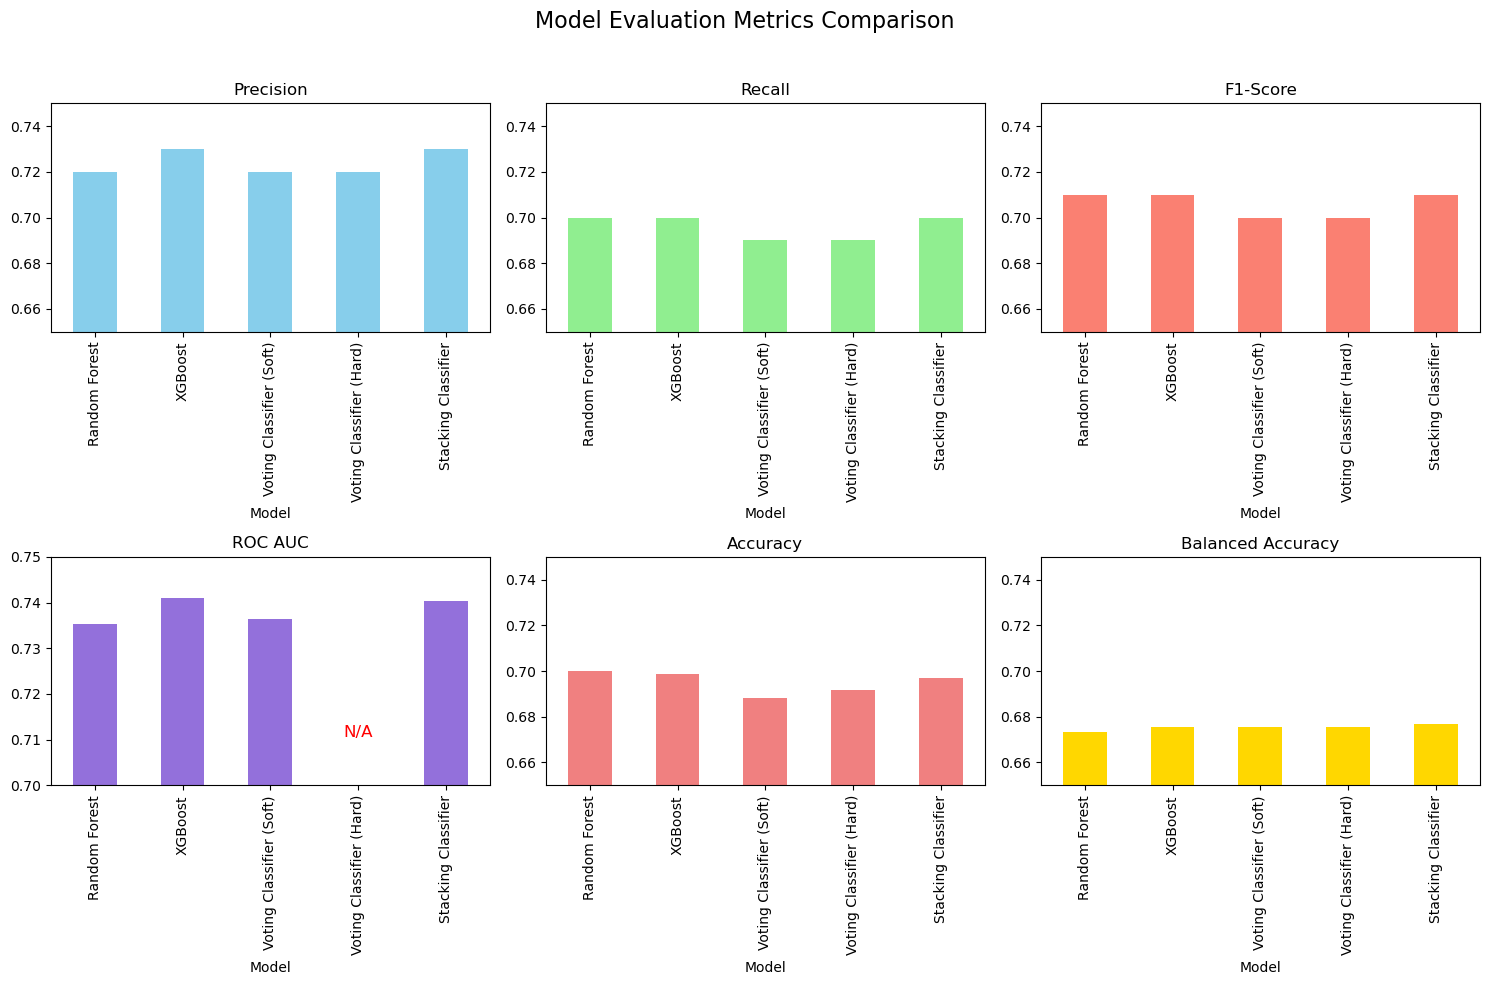

In [80]:
data = {
    'Model': [
        'Random Forest', 
        'XGBoost', 
        'Voting Classifier (Soft)', 
        'Voting Classifier (Hard)',
        'Stacking Classifier'
    ],
    'Precision': [0.72, 0.73, 0.72, 0.72, 0.73],
    'Recall': [0.70, 0.70, 0.69, 0.69, 0.70],
    'F1-Score': [0.71, 0.71, 0.70, 0.70, 0.71],
    'ROC AUC': [0.7352, 0.7411, 0.7364, 0, 0.7403],  # Placeholder for Voting Classifier (Hard)
    'Accuracy': [0.70, 0.6986, 0.6884, 0.6919, 0.6968],
    'Balanced Accuracy': [0.6733, 0.6756, 0.6756, 0.6755, 0.6768]
}

comp = pd.DataFrame(data)
comp.set_index('Model', inplace=True)

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Model Evaluation Metrics Comparison', fontsize=16)

# Plot Precision
comp['Precision'].plot(kind='bar', ax=ax[0, 0], color='skyblue', legend=False)
ax[0, 0].set_title('Precision')
ax[0, 0].set_ylim(0.65, 0.75)

# Plot Recall
comp['Recall'].plot(kind='bar', ax=ax[0, 1], color='lightgreen', legend=False)
ax[0, 1].set_title('Recall')
ax[0, 1].set_ylim(0.65, 0.75)

# Plot F1-Score
comp['F1-Score'].plot(kind='bar', ax=ax[0, 2], color='salmon', legend=False)
ax[0, 2].set_title('F1-Score')
ax[0, 2].set_ylim(0.65, 0.75)

# Plot ROC AUC
comp['ROC AUC'].plot(kind='bar', ax=ax[1, 0], color='mediumpurple', legend=False)
ax[1, 0].set_title('ROC AUC')
ax[1, 0].set_ylim(0.70, 0.75)
# Highlight missing ROC AUC value for Voting Classifier (Hard)
ax[1, 0].annotate('N/A', xy=(3, 0.71), ha='center', va='bottom', color='red', fontsize=12)

# Plot Accuracy
comp['Accuracy'].plot(kind='bar', ax=ax[1, 1], color='lightcoral', legend=False)
ax[1, 1].set_title('Accuracy')
ax[1, 1].set_ylim(0.65, 0.75)

# Plot Balanced Accuracy
comp['Balanced Accuracy'].plot(kind='bar', ax=ax[1, 2], color='gold', legend=False)
ax[1, 2].set_title('Balanced Accuracy')
ax[1, 2].set_ylim(0.65, 0.75)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("/Users/bennyschellinger/Desktop/DataScience/MLE_DataScientest/04_Projekt/MAY24_BDS_INT_Fire_Brigade/img/comp_test_perf_votingstacking.png")
plt.show()


In [81]:
comp

,Precision,Recall,F1-Score,ROC AUC,Accuracy,Balanced Accuracy
Model,,,,,,
Random Forest,0.72,0.70,0.71,0.7352,0.7000,0.6733
XGBoost,0.73,0.70,0.71,0.7411,0.6986,0.6756
Voting Classifier (Soft),0.72,0.69,0.70,0.7364,0.6884,0.6756
Voting Classifier (Hard),0.72,0.69,0.70,0.0000,0.6919,0.6755
Stacking Classifier,0.73,0.70,0.71,0.7403,0.6968,0.6768


In [141]:
model_eval = {
    'Model': [
        'Decision Tree (B)', 'Decision Tree (U)', 'Decision Tree (PCA+U)',
        'Decision Tree (Hyp)', 'Decision Tree (U+Hyp)', 'Decision Tree (PCA+U+Hyp)',
        'Random Forest (B)', 'Random Forest (U)', 'Random Forest (PCA+U)',
        'Random Forest (Hyp)', 'Random Forest (U+Hyp)', 'Random Forest (PCA+U+Hyp)'
    ],
    'Accuracy': [dt_test_acc, dt_test_acc_ru, dt_test_acc_pca_ru,
                 dt_test_acc_hyp, dt_test_acc_hyp_ru, dt_test_acc_hyp_ru_pca,
                 rf_test_acc, rf_test_acc_ru, rf_test_acc_pca_ru,
                 rf_test_acc_hyp, rf_test_acc_hyp_ru, rf_test_acc_hyp_ru_pca
                ],
    'Precision': [dt_test_prec, dt_test_prec_ru, dt_test_prec_pca_ru,
                  dt_test_prec_hyp, dt_test_prec_hyp_ru, dt_test_prec_hyp_ru_pca,
                  rf_test_prec, rf_test_prec_ru, rf_test_prec_pca_ru,
                  rf_test_prec_hyp, rf_test_prec_hyp_ru, rf_test_prec_hyp_ru_pca
                 ],
    'Recall': [dt_test_recall, dt_test_recall_ru, dt_test_recall_pca_ru,
               dt_test_recall_hyp, dt_test_recall_hyp_ru, dt_test_recall_hyp_ru_pca,
               rf_test_recall, rf_test_recall_ru, rf_test_recall_pca_ru,
               rf_test_recall_hyp, rf_test_recall_hyp_ru, rf_test_recall_hyp_ru_pca
              ],
    'F1 Score': [dt_test_f1, dt_test_f1_ru, dt_test_f1_pca_ru,
                 dt_test_f1_hyp, dt_test_f1_hyp, dt_test_f1_hyp_ru_pca,
                 rf_test_f1, rf_test_f1_ru, rf_test_f1_pca_ru,
                 rf_test_f1_hyp, rf_test_f1_hyp, rf_test_f1_hyp_ru_pca
                ],
    'ROC AUC Score': [dt_test_roc, dt_test_roc_ru, dt_test_roc_pca_ru,
                      dt_test_roc_hyp, dt_test_roc_hyp_ru, dt_test_roc_hyp_ru_pca,
                      rf_test_roc, rf_test_roc_ru, rf_test_roc_pca_ru,
                      rf_test_roc_hyp, rf_test_roc_hyp_ru, rf_test_roc_hyp_ru_pca,
                     ],
    'Balanced Accuracy': [dt_test_balacc, dt_test_balacc_ru, dt_test_balacc_pca_ru,
                          dt_test_balacc_hyp, dt_test_balacc_hyp_ru, dt_test_balacc_hyp_ru_pca,
                          rf_test_balacc, rf_test_balacc_ru, rf_test_balacc_pca_ru,
                          rf_test_balacc_hyp, rf_test_balacc_hyp_ru, rf_test_balacc_hyp_ru_pca,
                         ]
}

clf_test_eval = pd.DataFrame(model_eval)
clf_test_eval

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score,Balanced Accuracy
0,Decision Tree (B),0.673000,0.604131,0.602984,0.603532,0.603363,0.602984
1,Decision Tree (U),0.611450,0.592154,0.610060,0.584337,0.610380,0.610060
2,Decision Tree (PCA+U),0.586751,0.572970,0.587577,0.561326,0.587882,0.587577
3,Decision Tree (Hyp),0.719257,0.656694,0.553477,0.534563,0.642705,0.553477
4,Decision Tree (U+Hyp),0.701168,0.655239,0.672282,0.534563,0.731228,0.672282
5,Decision Tree (PCA+U+Hyp),0.697091,0.651330,0.668347,0.655980,0.727622,0.668347
6,Random Forest (B),0.743114,0.686924,0.638449,0.649350,0.724175,0.638449
7,Random Forest (U),0.673504,0.642369,0.666658,0.643073,0.727693,0.666658
8,Random Forest (PCA+U),0.666246,0.635151,0.658296,0.635321,0.716168,0.658296
9,Random Forest (Hyp),0.712295,0.792493,0.510725,0.437562,0.720772,0.510725


In [145]:
clf_test_eval.sort_values(by="Balanced Accuracy", ascending = False)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score,Balanced Accuracy
11,Random Forest (PCA+U+Hyp),0.698645,0.654644,0.673279,0.659372,0.735163,0.673279
4,Decision Tree (U+Hyp),0.701168,0.655239,0.672282,0.534563,0.731228,0.672282
5,Decision Tree (PCA+U+Hyp),0.697091,0.651330,0.668347,0.655980,0.727622,0.668347
7,Random Forest (U),0.673504,0.642369,0.666658,0.643073,0.727693,0.666658
10,Random Forest (U+Hyp),0.714773,0.658486,0.662336,0.437562,0.723892,0.662336
8,Random Forest (PCA+U),0.666246,0.635151,0.658296,0.635321,0.716168,0.658296
6,Random Forest (B),0.743114,0.686924,0.638449,0.649350,0.724175,0.638449
1,Decision Tree (U),0.611450,0.592154,0.610060,0.584337,0.610380,0.610060
0,Decision Tree (B),0.673000,0.604131,0.602984,0.603532,0.603363,0.602984
2,Decision Tree (PCA+U),0.586751,0.572970,0.587577,0.561326,0.587882,0.587577


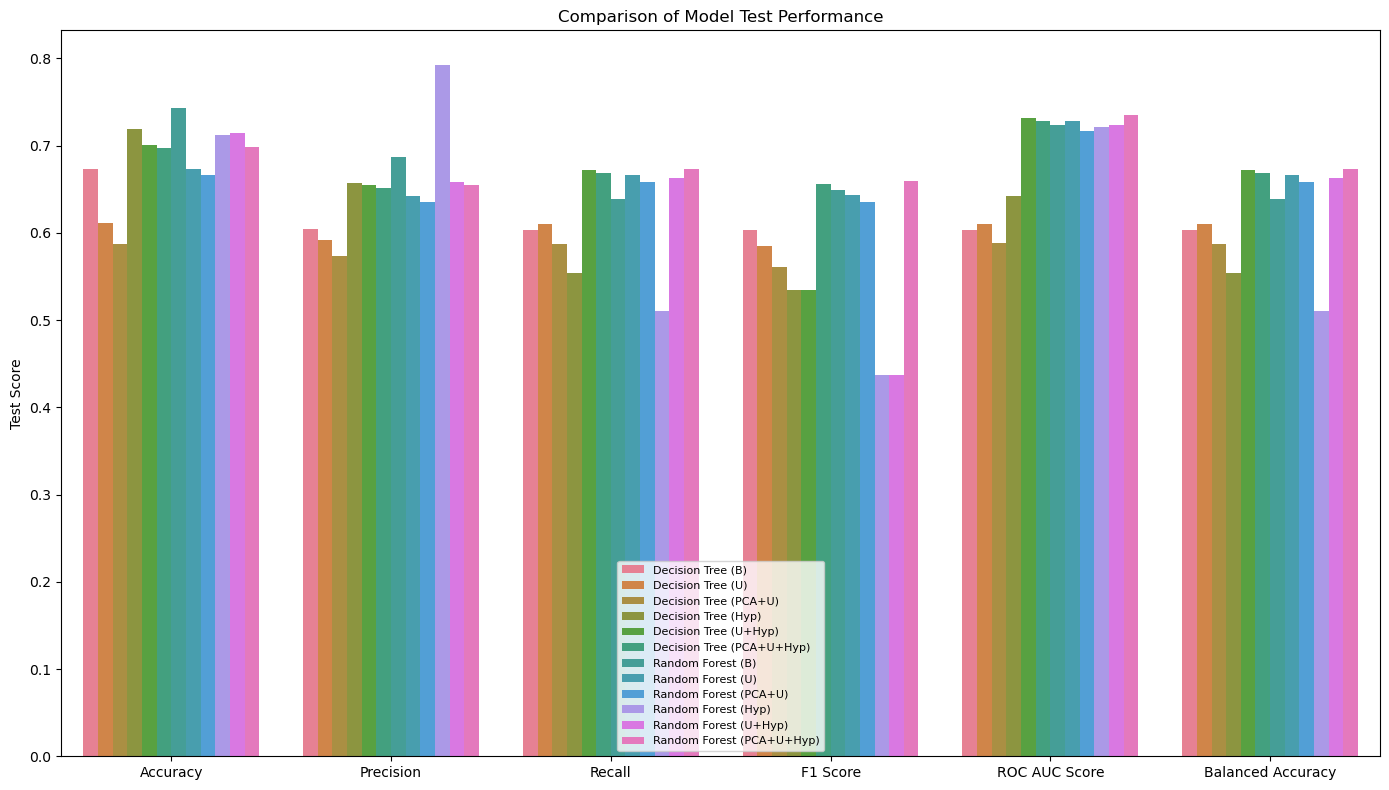

In [143]:
df_melted = clf_test_eval.melt(id_vars='Model', var_name='Metric', value_name='Score')

sns.set_palette('Set2')

plt.figure(figsize=(14, 8))
sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model')

plt.title('Comparison of Model Test Performance')
plt.xlabel('')
plt.ylabel('Test Score')
plt.legend(loc='lower center', prop={'size': 8}) 

plt.tight_layout()
plt.savefig("/Users/bennyschellinger/Desktop/DataScience/MLE_DataScientest/04_Projekt/MAY24_BDS_INT_Fire_Brigade/img/comp_test_perf_clf_models.png")
plt.show()

## 7.2 Receiver Operating Characteristic Curve

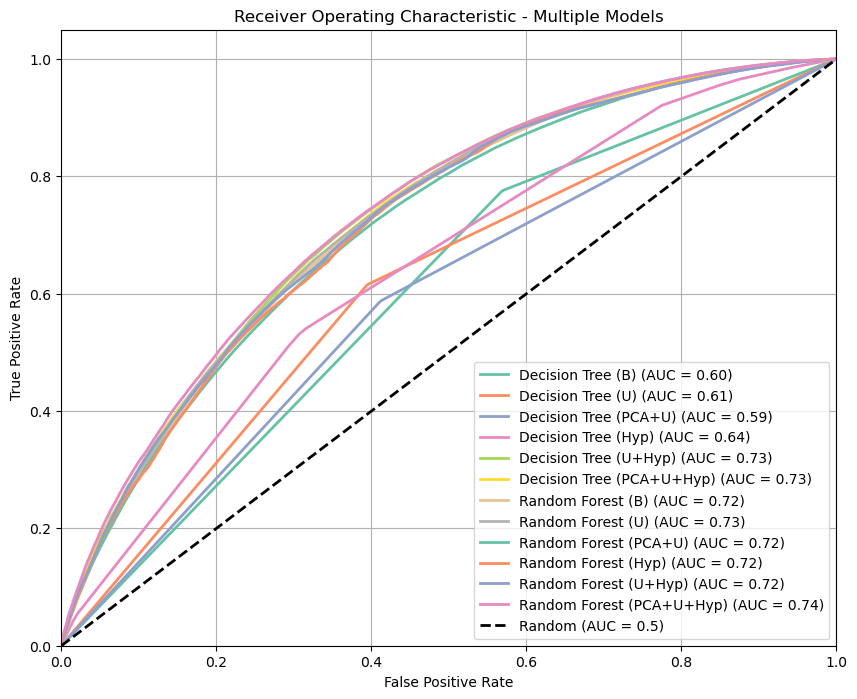

In [129]:
model_probas = {
    'Decision Tree (B)': y_test_pred_prob_dt,
    'Decision Tree (U)': y_test_pred_prob_dt_undsam,
    'Decision Tree (PCA+U)': y_test_pred_prob_dt_pca_ru,
    'Decision Tree (Hyp)': y_test_pred_prob_dt_hyp,
    'Decision Tree (U+Hyp)': y_test_pred_prob_dt_hyp_ru,
    'Decision Tree (PCA+U+Hyp)': y_test_pred_prob_dt_hyp_ru_pca,
    
    'Random Forest (B)': y_test_pred_prob_rf,
    'Random Forest (U)': y_test_pred_prob_rf_undsam,
    'Random Forest (PCA+U)': y_test_pred_prob_rf_pca_ru,
    'Random Forest (Hyp)': y_test_pred_prob_rf_hyp,
    'Random Forest (U+Hyp)': y_test_pred_prob_rf_hyp_ru,
    'Random Forest (PCA+U+Hyp)': y_test_pred_prob_rf_hyp_ru_pca
}

true_labels = {
    'Decision Tree (B)': y_test,
    'Decision Tree (U)': y_test,
    'Decision Tree (PCA+U)': y_test_pca,
    'Decision Tree (Hyp)': y_test,
    'Decision Tree (U+Hyp)': y_test,
    'Decision Tree (PCA+U+Hyp)': y_test_pca, 
    'Random Forest (B)': y_test,
    'Random Forest (U)': y_test,
    'Random Forest (PCA+U)': y_test_pca,
    'Random Forest (Hyp)': y_test,
    'Random Forest (U+Hyp)': y_test,
    'Random Forest (PCA+U+Hyp)': y_test_pca
}

def plot_roc_auc_multiple_models(true_labels, model_probas):
    plt.figure(figsize=(10, 8))
    
    for model_name, y_proba in model_probas.items():
        y_true = true_labels[model_name]
        fpr, tpr, _ = roc_curve(y_true, y_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    
    # Plot the random line
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random (AUC = 0.5)')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Multiple Models')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig("/Users/bennyschellinger/Desktop/DataScience/MLE_DataScientest/04_Projekt/MAY24_BDS_INT_Fire_Brigade/img/roc_test_perf_clf_models.png")
    plt.show()

plot_roc_auc_multiple_models(true_labels, model_probas)

# 8. Best Model & Parameter

#### Best Model:
-> Random Forest (Balanced + PCA + Hyperparameter Tuning)

### Best Parameter for RF

In [140]:
print(f'Best Parameters: {grid_search_rf_hyp_ru_pca.best_params_}')

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 200, 'random_state': 666}


In [144]:
best_model = grid_search_rf_hyp_ru_pca.best_estimator_
y_p = best_model.predict(X_test_pca)
balanced_acc = balanced_accuracy_score(y_test_pca, y_p)
print(f'Balanced Accuracy on Test Data: {balanced_acc:.4f}')

Balanced Accuracy on Test Data: 0.6733
